In [1]:
# if you use google colab use this line
# if you have local installation please make sure to use this version of matplotlib
# otherwise, some of the visualizations may not work
!pip install matplotlib==3.7.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#from cluster_algorithms import kMeans, OnlinekMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
import imageio


from IPython.display import Image
from copy import deepcopy

np.random.seed(42)

In [3]:
def build_figure(samples, centroids, labels, voronoi=True):

    fig = plt.figure(figsize=(9, 6))
    plt.rc('grid', linestyle="--", color='gray', alpha=0.5)

    if voronoi:
        vor = Voronoi(np.array(centroids))
        fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=plt.gca())

    plt.scatter(samples[:, 0], samples[:, 1], marker='x', s=10, c=get_color_palette(labels, color_map), alpha=0.2)

    for i, c in enumerate(centroids):
        plt.scatter(centroids[i][0], centroids[i][1], marker='x', s=100, color='red')

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Visualization of Samples from " + str(len(centroids)) + " Clusters")
    plt.grid(True)

    return fig

def animate_cluster(samples, centroids, labels, voronoi=True):
    figure = build_figure(samples, centroids, labels, voronoi=voronoi)
    return figure

def animate_kmeans_results(X, results, fps=2, voronoi=True):
    images = []
    for i in range(len(results)):
        fig = animate_cluster(X, results[i][0], results[i][1],  voronoi=voronoi)
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        images.append(image_from_plot)

    duration = int(1000 * 1 / fps)
    imageio.mimsave('./example.gif', images, fps=fps, duration=duration, loop=0)
    with open('./example.gif','rb') as f:
        display(Image(data=f.read(), format='png'))

def plot_elbow(wcss):
    plt.figure(figsize=(9, 6))
    plt.rc('grid', linestyle="--", color='gray', alpha=0.5)
    plt.plot(np.linspace(1, len(wcss), len(wcss)), wcss)

    plt.grid(True)
    plt.show()

# Task 9.1: A Structured Dataset

Create a dataset of two-dimensional vectors. Draw 1000 samples each from the normal distributions
with

$
\mu_1 = \begin{pmatrix} 1 \\ 1\end{pmatrix},
\Sigma_1 = \begin{pmatrix} 0.5 & 0.2 \\ 0.2 & 0.5 \end{pmatrix},
\mu_2 = \begin{pmatrix} 0 \\ -2\end{pmatrix},
\Sigma_2 = \begin{pmatrix} 0.3 & 0.2 \\ 0.2 & 0.2 \end{pmatrix},
\mu_3 = \begin{pmatrix} -2 \\ -1\end{pmatrix},
\Sigma_3 = \begin{pmatrix} 0.1 & 0.2 \\ 0.2 & 0.8 \end{pmatrix}
$

Each normal distribution results in one cluster of points.
Visualize the position of the points and clusters and use this set for the next exercises.

In [4]:
# helper functions for visualization

def get_color_palette(labels, color_map):
    return [color_map[l] for l in labels if l < len(color_map)]

def visualize_cluster(samples, centroids, labels, voronoi=True):
    fig = plt.figure(figsize=(9, 6))
    plt.rc('grid', linestyle="--", color='gray', alpha=0.5)

    if voronoi:
        vor = Voronoi(np.array(centroids))
        fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=plt.gca())

    plt.scatter(samples[:, 0], samples[:, 1], marker='x', s=10, c=get_color_palette(labels, color_map), alpha=0.2)

    for i, c in enumerate(centroids):
        plt.scatter(centroids[i][0], centroids[i][1], marker='x', s=100, color='red')

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Visualization of Samples from " + str(len(centroids)) + " Clusters")
    plt.grid(True)
    plt.show()

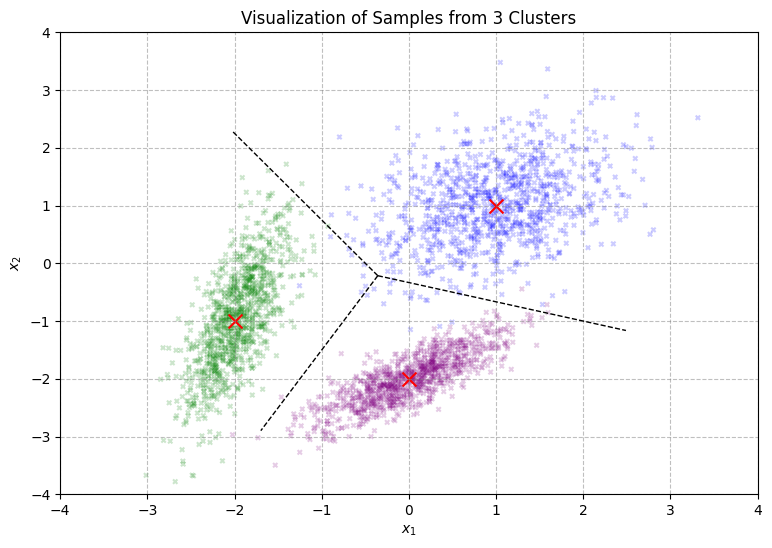

In [5]:
# TODO: generate the data points from the three clusters and use the function visualize_cluster to visualize the dataset

N = 1000
color_map = ["green", "purple", "blue", "magenta", "orange", "gray", "pink", "maroon", "cyan", "olive"]

# TODO: Define parameters for the normal distributions
mu_1 = np.array([1, 1])
cov_1 = np.array([[0.5, 0.2], [0.2, 0.5]])

mu_2 = np.array([0, -2])
cov_2 = np.array([[0.3, 0.2], [0.2, 0.2]])

mu_3 = np.array([-2, -1])
cov_3 = np.array([[0.1, 0.2], [0.2, 0.8]])

centroids_true = np.array([np.array(mu_1), np.array(mu_2), np.array(mu_3)])

# TODO: Generate samples from the three normal distributions
samples_1 = np.random.multivariate_normal(mu_1, cov_1, N)
samples_2 = np.random.multivariate_normal(mu_2, cov_2, N)
samples_3 = np.random.multivariate_normal(mu_3, cov_3, N)
labels =  [2]*N + [1]*N  + [0]*N

# TODO: Visualize the clusters (with function visualize_cluster)
# Concatenate the samples
X = np.concatenate([samples_1, samples_2, samples_3])
visualize_cluster(X, centroids_true, labels)

# Task 9.2: K-means Clustering

a) Implement the ”K-means Clustering” algorithm and use it on the dataset you created in the last task. Initialize the algorithm with $K = 3$ randomly chosen prototypes first. Then repeat the experiment with $K = 5$ and $K = 10$ prototypes.

In [6]:

class kMeans:
    def __init__(self, k=2, max_iter=1000, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = []
        self.results = []

    def fit(self, X):
        # TODO: implement K-means clustering
        # TODO: initialize centroids
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

        for i in range(self.max_iter):
            self.results.append([self.centroids, self.predict(X)])

            # TODO: E-Step: Assign clusters
            clusters = self.assign_classes(X)

            # TODO: M-Step: Calculate new centroids
            new_centroids = np.array([X[clusters == j].mean(axis=0) for j in range(self.k)])

            # TODO: Check for convergence
            if np.linalg.norm(new_centroids - self.centroids, axis=1).sum() < self.tol:
                break

            # TODO: Update centroids
            self.centroids = new_centroids

    def predict(self, X):
        # Assign clusters to new data
        return self.assign_classes(X)

    def assign_classes(self, X):
        # TODO: Calculate distances to centroids
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        # Assign the closest cluster to each point
        return np.argmin(distances, axis=0)

    def calculate_wcss(self, X):
        labels = self.predict(X)
        self.wcss = 0.0
        for i, centroid in enumerate(self.centroids):
            cluster_points = X[labels == i]
            self.wcss += np.sum((cluster_points - centroid) ** 2)

Centroid 0 (predicted): [-1.96938638 -0.96583434]
Centroid 1 (predicted): [ 0.00765334 -1.9714975 ]
Centroid 2 (predicted): [0.9856559  1.04064831]


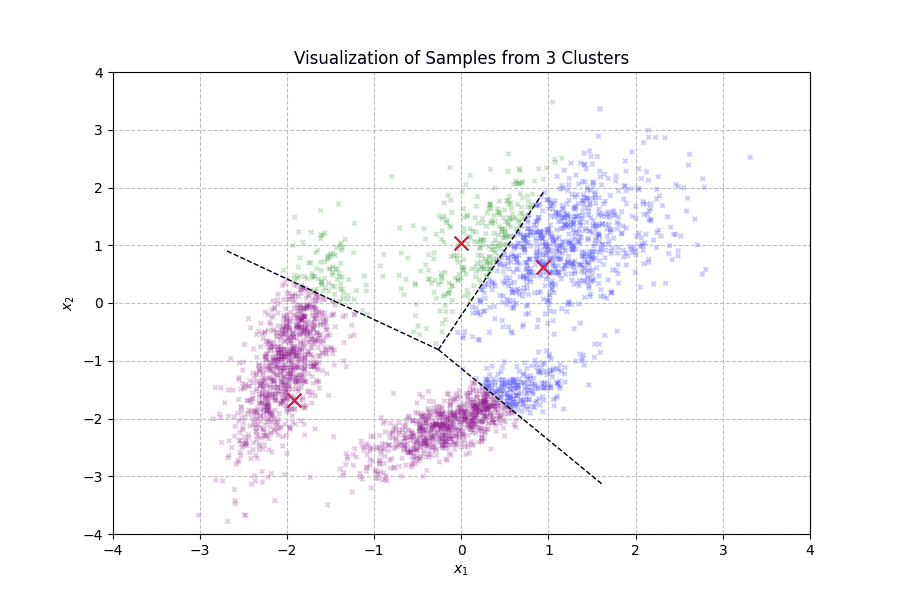

In [7]:
# TODO: Run kMeans with k = 3
kmeans = kMeans(k=3, max_iter=1000)
kmeans.fit(X)
labels = kmeans.predict(X)
results = kmeans.results

# Compare centroids
for i, c in enumerate(kmeans.centroids): print("Centroid {} (predicted): {}".format(i, c))

# TODO: visualize results
animate_kmeans_results(X, results)

Centroid 0 (predicted): [-1.78421878 -0.29085386]
Centroid 1 (predicted): [1.45743287 1.49552608]
Centroid 2 (predicted): [0.58966288 0.60850767]
Centroid 3 (predicted): [ 0.02184823 -1.98580108]
Centroid 4 (predicted): [-2.13956468 -1.73823347]


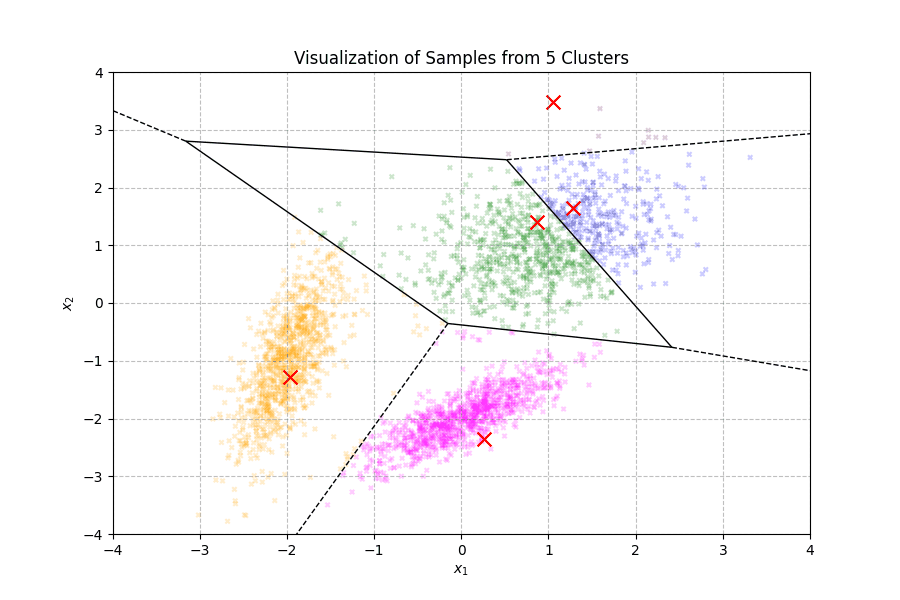

In [8]:
# TODO: Run kMeans with k = 5
kmeans = kMeans(k=5)
kmeans.fit(X)
labels = kmeans.predict(X)
results = kmeans.results

for i, c in enumerate(kmeans.centroids): print("Centroid {} (predicted): {}".format(i, c))

# TODO: visualize result
animate_kmeans_results(X, results)

Centroid 0 (predicted): [1.38760796 0.73507644]
Centroid 1 (predicted): [-0.63476249 -2.4865314 ]
Centroid 2 (predicted): [ 0.02589666 -1.99266109]
Centroid 3 (predicted): [0.35673319 0.7671756 ]
Centroid 4 (predicted): [ 0.66548759 -1.37330334]
Centroid 5 (predicted): [-1.48939266  0.51677745]
Centroid 6 (predicted): [-2.04288147 -1.23704841]
Centroid 7 (predicted): [-1.82609175 -0.41111395]
Centroid 8 (predicted): [1.40765705 1.79113934]
Centroid 9 (predicted): [-2.30152831 -2.21441531]


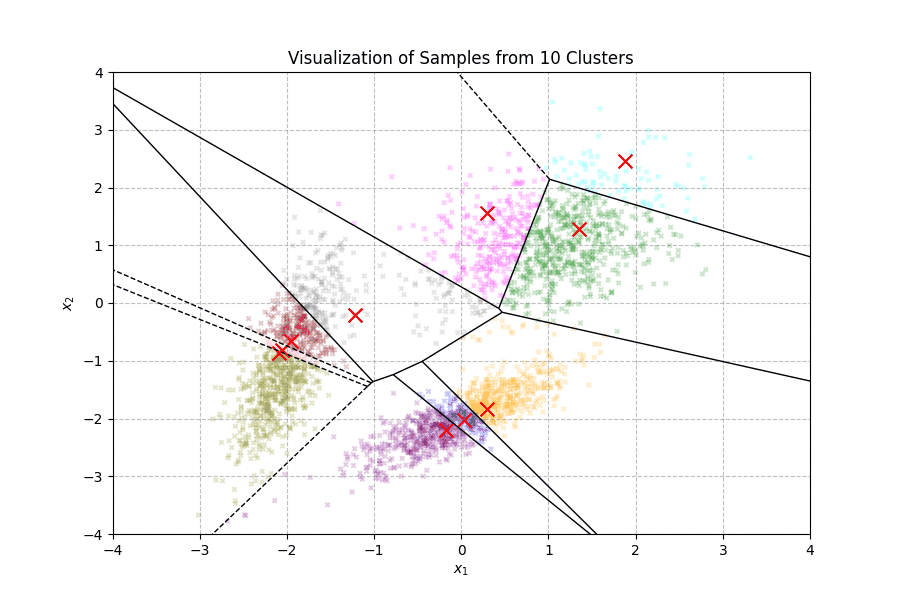

In [9]:
# TODO: Run kMeans with k = 10
kmeans = kMeans(k=10)
kmeans.fit(X)
labels = kmeans.predict(X)
results = kmeans.results

for i, c in enumerate(kmeans.centroids): print("Centroid {} (predicted): {}".format(i, c))

# TODO: svisualize results
animate_kmeans_results(X, results)

b) As we randomly initialize k clusters we iteratively adjust these k clusters till the k centroids reach an equilibrium state. However, the main thing we do before initializing these clusters is to determine how many clusters we have to use. To do so, there is the ”Elbow Method”. For every value of k = [1, ..., kmax], calculate the within-cluster sum of squares (WCSS) value. After that plot the WCSSs and determine the optimal k.

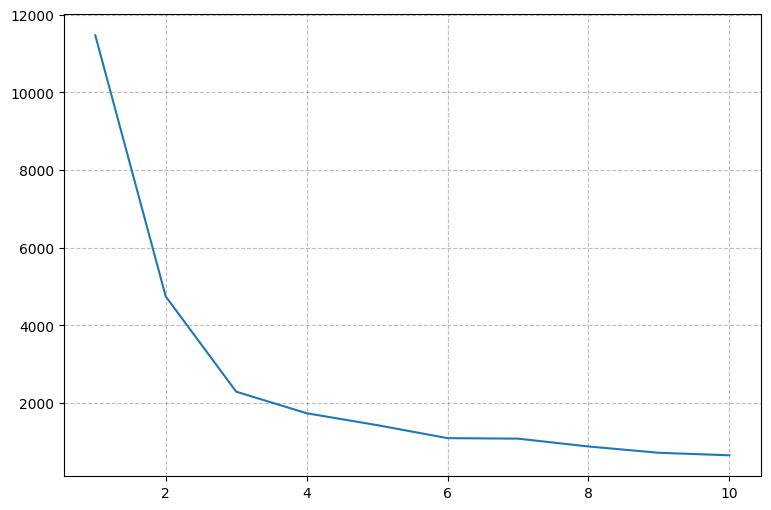

In [10]:
# b) TODO: In class kMeans implement the function calculate_wcss

# TODO: Calculate the WCSS for k = [1, 10] and plot the WCSS's for all k.
wcsss = []
max_k = 10
for k in range(1, max_k + 1):
    kmeans = kMeans(k=k, max_iter=200)
    kmeans.fit(X)
    kmeans.calculate_wcss(X)
    wcsss.append(kmeans.wcss)

plot_elbow(wcsss)

# Effect of strongly different in-cluster variances on K-means

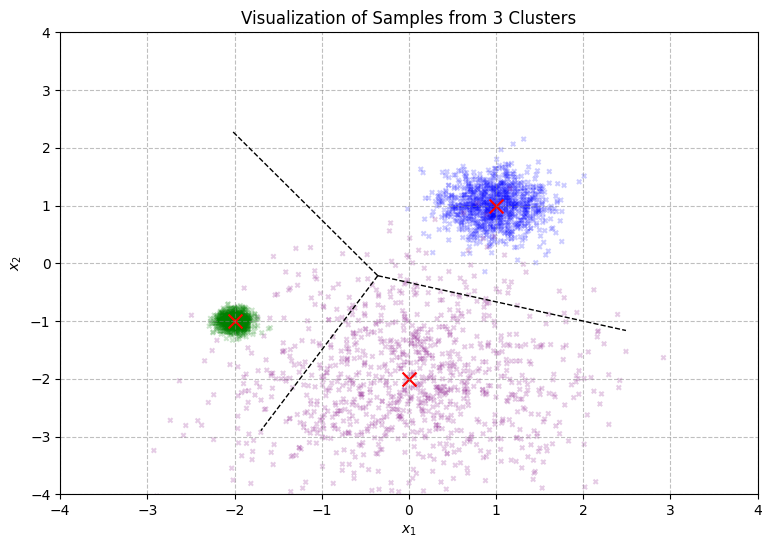

In [11]:
# TODO: generate the data points from the three clusters and use the function visualize_cluster to visualize the dataset

N = 1000
color_map = ["green", "purple", "blue", "magenta", "orange", "gray", "pink", "maroon", "cyan", "olive"]

# TODO: Define parameters for the normal distributions
mu_1 = np.array([1, 1])
cov_1 = np.array([[0.1, 0], [0, 0.1]])

mu_2 = np.array([0, -2])
cov_2 = np.array([[1, 0], [0, 1]])

mu_3 = np.array([-2, -1])
cov_3 = np.array([[0.01, 0], [0, 0.01]])

centroids_true = np.array([np.array(mu_1), np.array(mu_2), np.array(mu_3)])

# TODO: Generate samples from the three normal distributions
samples_1 = np.random.multivariate_normal(mu_1, cov_1, N)
samples_2 = np.random.multivariate_normal(mu_2, cov_2, N)
samples_3 = np.random.multivariate_normal(mu_3, cov_3, N)
labels =  [2]*N + [1]*N  + [0]*N

# TODO: Visualize the clusters (with function visualize_cluster)
# Concatenate the samples
X2 = np.concatenate([samples_1, samples_2, samples_3])
visualize_cluster(X2, centroids_true, labels)

Centroid 0 (predicted): [ 0.21305431 -2.27852119]
Centroid 1 (predicted): [-1.92342951 -1.06432097]
Centroid 2 (predicted): [0.96033758 0.92473163]


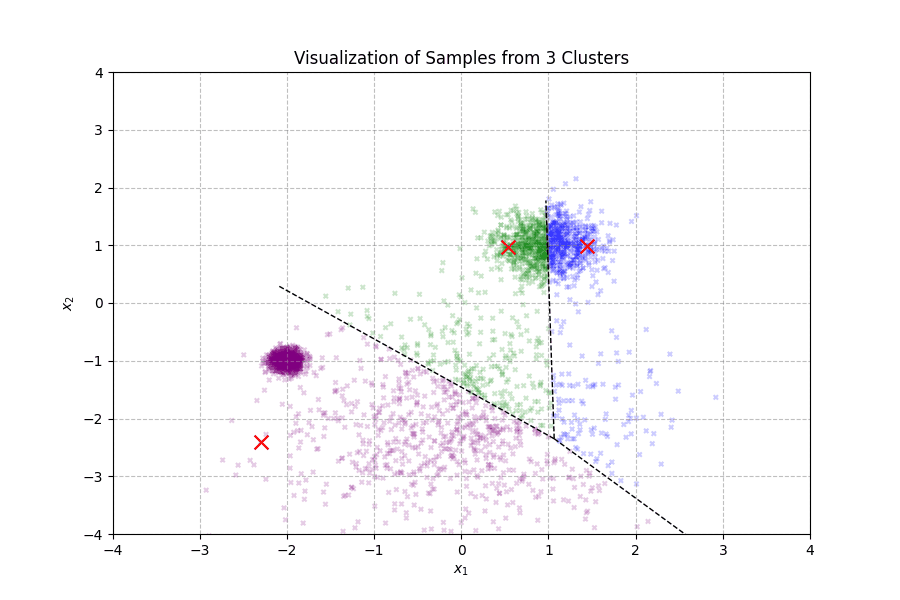

In [12]:
# Run K-Means with k=3
kmeans = kMeans(k=3)
kmeans.fit(X2)
labels = kmeans.predict(X2)
results = kmeans.results

for i, c in enumerate(kmeans.centroids): print("Centroid {} (predicted): {}".format(i, c))

# TODO: svisualize results
animate_kmeans_results(X2, results)

c) Now implement the online variant of K-means and use it on the same dataset. Choose the prototypes as above. Again visualize the steps of the algorithm. Explain the results and the differences compared to a).

In [13]:
class OnlinekMeans(kMeans):
    def __init__(self, prototypes=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.centroids = None if not prototypes else  np.array(prototypes, dtype=np.float32)
        self.counts = np.zeros(self.k)

    def fit(self, X):
        # TODO: Randomly initialize centroids
        if self.centroids is None:
            self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

        for _ in range(self.max_iter):
            centroids_pre = deepcopy(self.centroids)

            for x in X:
                # TODO: E-Step: Find the closest centroid
                closest = np.argmin(np.linalg.norm(x-self.centroids, axis=1))

                # TODO: Update the count for the closest centroid
                self.counts[closest] += 1
                n = self.counts[closest]

                # TODO: M-Step: Update centroids
                self.centroids[closest] += (1/n) * (x - self.centroids[closest])
            self.results.append([self.centroids, self.predict(X)])

            # TODO: stop if change is smaller than tolerance
            if np.linalg.norm(centroids_pre-self.centroids, axis=1).sum() < self.tol:
                break

Centroid 0 (predicted): [0.98906401 1.03882596]
Centroid 1 (predicted): [-0.01978648 -1.97544522]
Centroid 2 (predicted): [-1.96088224 -0.94877934]


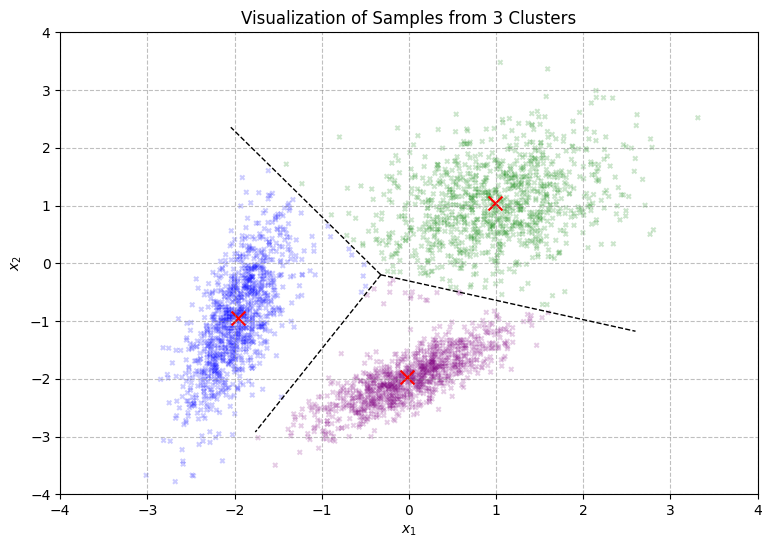

In [14]:
# TODO: Run online Kmeans with k = 3 and visualize result
online_kmeans = OnlinekMeans(k=3, max_iter=1000, tol=1e-4)
online_kmeans.fit(X)
labels = online_kmeans.predict(X)
centroids = online_kmeans.centroids
results = online_kmeans.results

for i, c in enumerate(centroids): print("Centroid {} (predicted): {}".format(i, c))

visualize_cluster(X, centroids, labels, voronoi=True)

d) Again, determine the optimal number of cluster centroids k for the online variant of K-means.

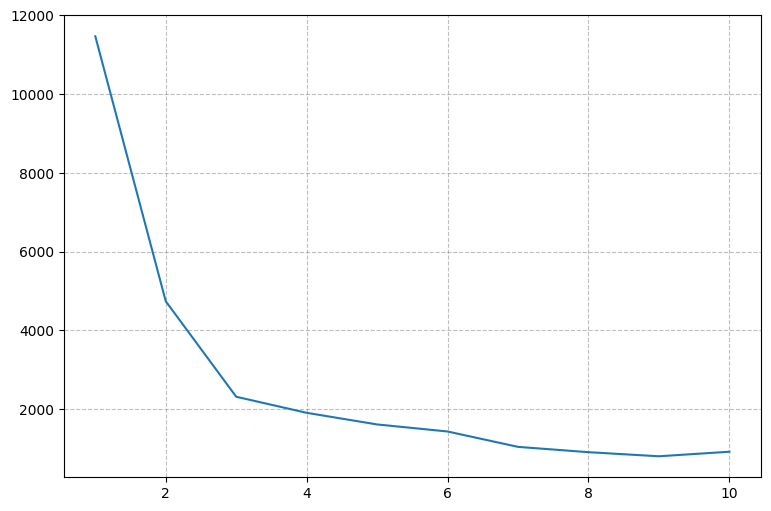

In [20]:
# d) TODO: Calculate the WCSS for k = [1, 10], plot the WCSS's for all k, and determine the optimal k.
wcsss = []
max_k = 10
for k in range(1, max_k + 1):
    kmeans = OnlinekMeans(k=k, max_iter=100, tol=1e-4)
    kmeans.fit(X)
    kmeans.calculate_wcss(X)
    wcsss.append(kmeans.wcss)

plot_elbow(wcsss)

# Task 9.3: Another Structured Dataset

a) Generate a dataset of three-dimensional vectors $(x_1, x_2, x_3)^T$ . Draw 2000 samples in the following way:

For $x_3 = 0$ draw $x_1, x_2$ normally distributed with $μ_1 = [0; 0], Σ_1 = [0.5, 0; 0, 0.5]$ (1000 samples). The
other 1000 samples should be uniformly distributed within a cylinder that has the base in the $x_1, x_2$
surface (center (0, 0), radius 0.5) and the axis along the $x_3$-axis from $x_3 = 0$ to $x_3 = 5$.


In [21]:
# helper functions for visualization

def visualize_3d(X, centroids=None, labels=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    if labels is not None:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.05, c=get_color_palette(labels, color_map))
    else:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.05)
    if centroids is not None:
        for i, c in enumerate(centroids):
            ax.scatter(centroids[i][0], centroids[i][1], centroids[i][2], marker='x', color='green', s=100)


    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.set_title('3D Dataset Visualization')
    plt.show()

In [22]:
def generate_3d_dataset(mu, cov):
    # Generating samples for x3 = 0
    samples_x3_0 = np.random.multivariate_normal(mu, cov, 1000)
    samples_x3_0 = np.hstack((samples_x3_0, np.zeros((1000, 1))))  # Adding x3 = 0

    # Generating uniformly distributed samples within a cylinder
    angle = np.random.uniform(0, 2 * np.pi, 1000)
    radius = np.random.uniform(0, 0.5, 1000)
    x1 = radius * np.cos(angle)
    x2 = radius * np.sin(angle)
    x3 = np.random.uniform(0, 5, 1000)
    samples_cylinder = np.vstack((x1, x2, x3)).T

    # Combining the samples
    all_samples = np.vstack((samples_x3_0, samples_cylinder))

    return all_samples

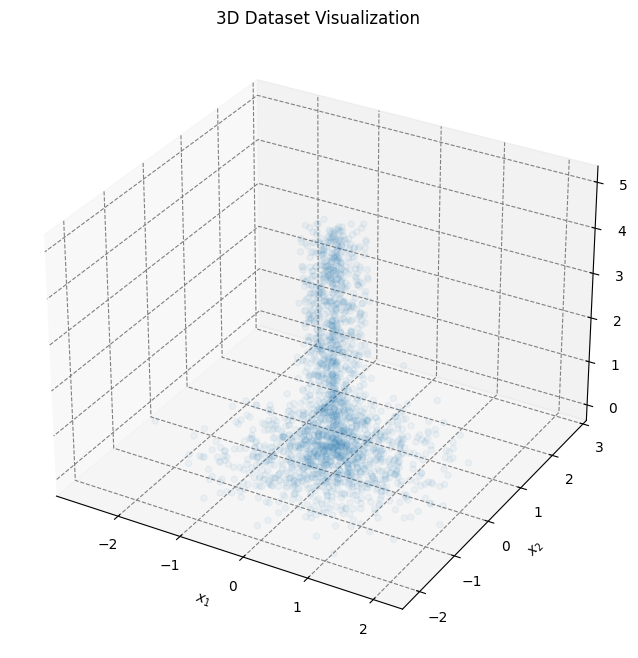

In [23]:
# TODO: generate dataset
mu = np.array([0, 0])
cov = np.array([[0.5, 0], [0, 0.5]])

# Generate the 3D dataset
X = generate_3d_dataset(mu, cov)

visualize_3d(X)

b) Use online K-means with the following initialization on your dataset

1. More than two prototypes on the $x_3$-axis;

=> The prototypes will likely move to positions that minimize the distance to the points distributed along the cylinder.


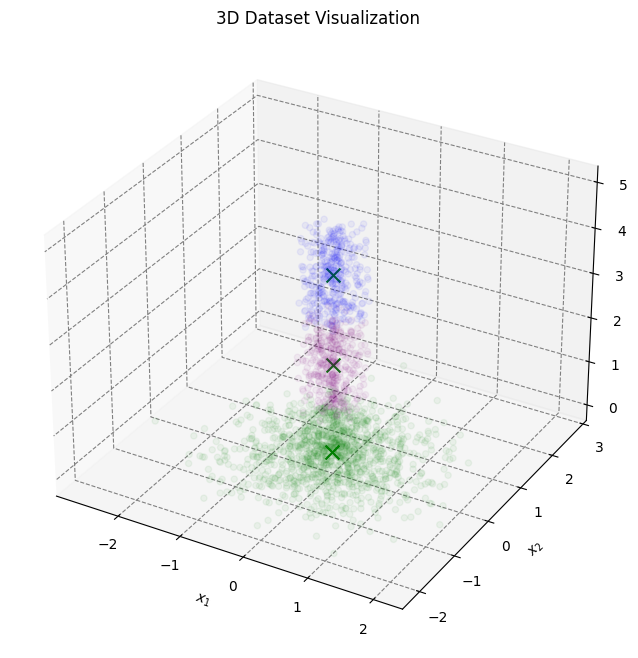

In [24]:
# TODO: define initial prototypes run Online Kmeans and visualize results
initial_prototypes = [[0.0, 0.0, 1.0], [0.0, 0.0, 3.0], [0.0, 0.0, 5.0]]

print('=> The prototypes will likely move to positions that minimize the distance to the points distributed along the cylinder.')

online_kmeans = OnlinekMeans(k=3, max_iter=1000, prototypes=initial_prototypes)
online_kmeans.fit(X)
centroids = online_kmeans.centroids
labels=online_kmeans.predict(X)

visualize_3d(X, centroids, labels)

2. More than two prototypes on the x3-axis, one of those with $x_3 = 0$

=> The prototype at x3 = 0 will likely move towards the center of the normal distribution, while the others adjust to the cylindrical distribution.


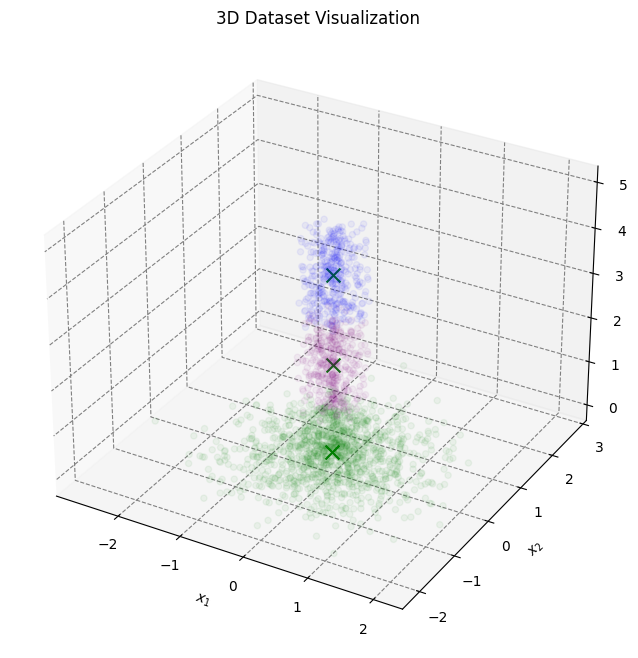

In [29]:
# TODO: define initial prototypes run Online Kmeans and visualize results
initial_prototypes = [[0.25, 0.25, 0], [0, 0, 1.5], [0, 0, 5]]

print('=> The prototype at x3 = 0 will likely move towards the center of the normal distribution, while the others adjust to the cylindrical distribution.')

online_kmeans = OnlinekMeans(k=3, max_iter=1000, prototypes=initial_prototypes)
online_kmeans.fit(X)
centroids = online_kmeans.centroids
labels=online_kmeans.predict(X)

visualize_3d(X, centroids, labels)

3. Two prototypes with $x_3 = 0$

=>  These prototypes will likely converge towards the center of the normal distribution around (0, 0, 0) and the center of the cylinder around (0, 0, 2.5).


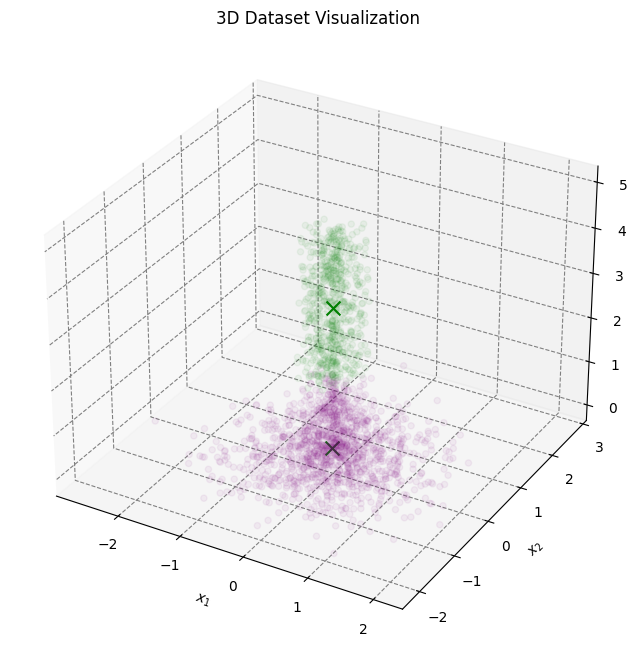

In [30]:
# TODO: define initial prototypes run Online Kmeans and visualize results
initial_prototypes = [[-0.5, 0.0, 0.0], [0.5, 0., 0.0]]
print('=>  These prototypes will likely converge towards the center of the normal distribution around (0, 0, 0) and the center of the cylinder around (0, 0, 2.5).')


online_kmeans = OnlinekMeans(k=2, max_iter=1000, prototypes=initial_prototypes)
online_kmeans.fit(X)
centroids = online_kmeans.centroids
labels = online_kmeans.predict(X)

visualize_3d(X, centroids, labels)

4. One prototype with $x_3 = 0$, one on the $x_1, x_3$ surface.(Changed from Task on Sheet, because task on sheet is not different from task 3)

=>  The prototype at x3 = 0 will move towards the center of the normal distribution, and the other will likely adjust to represent the cylindrical distribution, possibly moving towards its central axis.


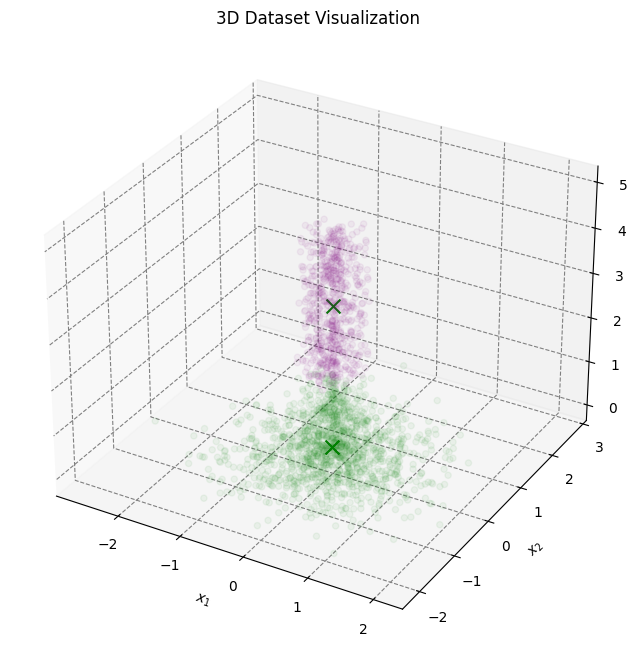

In [31]:
# TODO: define initial prototypes run Online Kmeans and visualize results
initial_prototypes = [[0.5, 0.5, 0.0], [0.0, 0.0, 1.5]]
print('=>  The prototype at x3 = 0 will move towards the center of the normal distribution, and the other will likely adjust to represent the cylindrical distribution, possibly moving towards its central axis.')

online_kmeans = OnlinekMeans(k=2, max_iter=1000, prototypes=initial_prototypes)
online_kmeans.fit(X)
centroids = online_kmeans.centroids
labels = online_kmeans.predict(X)

visualize_3d(X, centroids, labels)

c) Again, determine the optimal number of cluster centroids $k$ for the online variant of K-means.


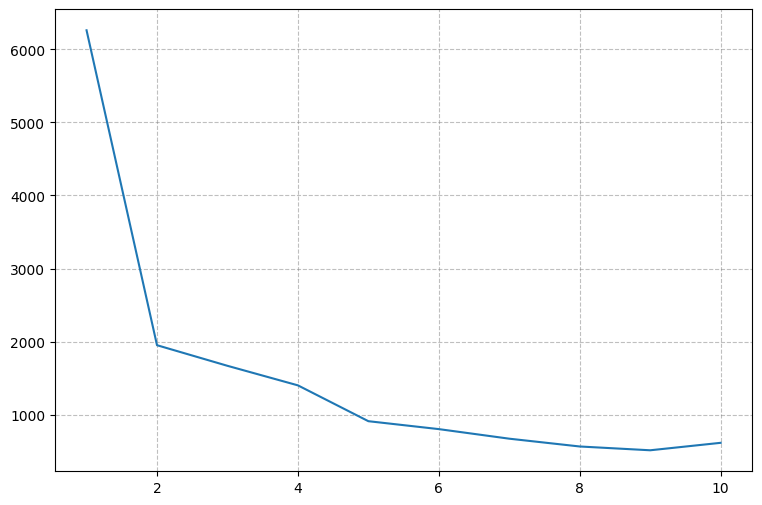

In [28]:
# TODO: calculate wcss and visualize results
wcsss = []
max_k = 10
for k in range(1, max_k + 1):
    kmeans = OnlinekMeans(k=k, max_iter=100)
    kmeans.fit(X)
    kmeans.calculate_wcss(X)
    wcsss.append(kmeans.wcss)

plot_elbow(wcsss)